In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

import imageio as img

import math
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

In [2]:
# setting variables for the directory to the data
todata = "/home/abdullah/Desktop/Abdullah/LUMS/Senior/Sproj/ImgPreProcessing/Channel/"
moredata = "/home/abdullah/Desktop/Abdullah/LUMS/Senior/Sproj/ImgPreProcessing/AmplifiedDataset"


training_iters = 1001
learning_rate = 0.0003 
batch_size = 64

# data input (img shape: 28*28)
n_input = 28

# total classes (0-9 digits)
n_classes = 26

norm = 255.0

In [3]:
# saving current directory
cur = os.getcwd()

# changing directoy to data set
os.chdir(todata)
# getting all the folder names
nmes = os.listdir(".")
nmes.sort()

# reading all the data into labels and data numpy arrays
labels = []
data = []
for letr in nmes:
    for file in os.listdir(todata+letr):
        labels.append(letr)
        f = img.imread(todata + letr + "/"+ file)
        data.append(f)
#         print(f.shape)
#         plt.imshow(f)
#         plt.show()
#         break
#     break
        # change back directory
os.chdir(cur)

print("\nData labales matrix")
labels = np.array(labels)
print(labels, labels.dtype, labels.shape)

# diving by 255 to get clamp values between zero and one
print("\nData matrix")
data = np.array(data, np.float32)/norm
print(data.dtype, data.shape)



Data labales matrix
['A' 'A' 'A' ... 'Z' 'Z' 'Z'] <U1 (3844,)

Data matrix
float32 (3844, 28, 28)


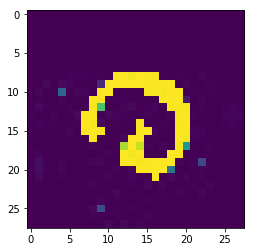

In [4]:
plt.imshow(data[1000])
plt.show()

In [5]:
# converting labels into onehot encodings

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
# print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded.shape)

(3844, 26)


/home/abdullah/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
# function that splits up the data

def train_val_split(data, labels, keep):
  

    data = np.array(data)
    labels = np.array(labels)

    #split the data
    number_of_validation_points = data.shape[0]

    split = int(number_of_validation_points*keep)

    # getting curent state so shuffle is the same for both arrays
    curState = np.random.get_state()
    np.random.shuffle(data)
    # setting the state
    np.random.set_state(curState)
    np.random.shuffle(labels)



    #images are unflattened
    temp_val = data[split:]
    val_label = labels[split:]
    temp_train = data[:split]
    train_label = labels[:split]

    val = temp_val
    train = temp_train
    
    train = np.array(train)
    val = np.array(val)

    print("The splits are: ")
    print(train.shape)   
    print(train_label.shape)
    print(val.shape) 
    print(val_label.shape)

    return train, train_label, val, val_label



In [7]:
# splitting up the data
tr, tr_l, vl, vl_l = train_val_split(data, onehot_encoded, 0.8)



The splits are: 
(3075, 28, 28)
(3075, 26)
(769, 28, 28)
(769, 26)


In [8]:
# Reshape training and testing image
train_X = tr.reshape(-1, n_input, n_input, 1)
test_X = vl.reshape(-1,n_input,n_input, 1)



train_y = tr_l
test_y = vl_l

train_X.shape, test_X.shape, train_y.shape, test_y.shape

((3075, 28, 28, 1), (769, 28, 28, 1), (3075, 26), (769, 26))

In [12]:
# tensorflow variables will be assigned inside the functions

# simple convolution layer
def conv_layer(inp, ch_in, ch_out, kernel, name="conv", strides=1, k=2):
    # giving the same naming structure for graph in tensorboard
    with tf.name_scope(name):
        # the first two are kernel dimen then its the input depth and 
        # then the number of filters you want ie output depth
        w = tf.Variable(tf.truncated_normal([kernel, kernel, ch_in, ch_out], stddev=0.3), name="W")
        b = tf.Variable(tf.constant(0.01, shape=[ch_out]), name="B")

        # applying the kernel
        conv = tf.nn.conv2d(inp, w, strides=[1, strides, strides,1], padding="SAME")

        # activation
        conv = tf.nn.bias_add(conv, b)
        act = tf.nn.tanh(conv)
        
        # summaries
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return tf.nn.max_pool(act, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# fully connected layer
def fc_layer(inp, ch_in, ch_out, name="fullyConnected"):
    # giving the same naming structure for graph in tensorboard
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([ch_in, ch_out], stddev=0.3), name="W")
        b = tf.Variable(tf.constant(0.01, shape=[ch_out]), name="B")

        # linear operation and activation
        fc = tf.matmul(inp, w)
        fc = tf.nn.bias_add(fc, b)
        act = tf.nn.tanh(fc)
        act = tf.nn.dropout(act, 0.9)
        # summaries
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

def outter(inp, ch_in, ch_out, name="outer"):
    # giving the same naming structure for graph in tensorboard
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([ch_in, ch_out], stddev=0.3), name="W")
        b = tf.Variable(tf.constant(0.01, shape=[ch_out]), name="B")

        # linear operation and activation
        act = tf.matmul(inp, w)
        act = tf.nn.bias_add(act, b)
        # summaries
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

In [13]:
# the whole compuational graph/network
def conv_net(x):  

    # pooling is done inside the conv layers
    # here we call the convolution layer we had defined above and pass the input image x
    # since image is grascale input channel = 1 and output we specified to 32 kernels
    conv1 = conv_layer(x, 1, 32, 3, "conv1")

    # here we call the convolution layer we had defined above.
    conv2 = conv_layer(conv1, 32, 64, 3, "conv2")


    
    conv3 = conv_layer(conv2, 64, 128, 4, "conv3")

    

    # flatten the ouput of pool for fully connected
    # Reshape output to fit fully connected layer input
    flat = tf.reshape(conv3, [-1, math.ceil(n_classes/8)*math.ceil(n_classes/8)*128])

    # Fully connected layer
    fc1 = fc_layer(flat, math.ceil(n_classes/8)*math.ceil(n_classes/8)*128, 1024, "fc1")

    fc2 = fc_layer(fc1, 1024, 512, "fc2")
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = outter(fc2, 512, n_classes,"out")

    return out

In [14]:
tf.reset_default_graph()
sess = tf.Session()# telling the session to initialize the variables


# input dimen and output dimen
x = tf.placeholder("float", [None, n_input,n_input, 1], name="x")
tf.summary.image('input', x, 10)

y = tf.placeholder("float", [None, n_classes], name = "labels")

# storing the graph in the variable pred
pred = conv_net(x)

# getting output for prediction
yOut = tf.identity(pred, name="myOutput")

# cost fucntion for the graph
with tf.name_scope("entropy"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    tf.summary.scalar("entropy", cost)

# optiizr for the network
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

with tf.name_scope("accuracy"):
    #Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled 
    #image. and both will be a column vector.
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

    #calculate accuracy across all the given images and average them out. 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    tf.summary.scalar("accuracy", accuracy)
    
# Initializing the variables
init = tf.global_variables_initializer()
sess.run(init) 

# storing the values in lists
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

summ = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter('./Output')
summary_writer.add_graph(sess.graph)

for i in range(1,training_iters):
    for batch in range(len(train_X)//batch_size):
        batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
        batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
        # Run optimization op (backprop).
        # Calculate batch loss and accuracy
        opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})

        if (i % 5 == 0)&(batch == 0):
            s = sess.run(summ, feed_dict={x: batch_x, y: batch_y})
            summary_writer.add_summary(s, i)
    if i % 10 == 0:
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
#         print("Optimization Finished!")

    # Calculate accuracy for all test images
    train_loss.append(loss)
    train_accuracy.append(acc)
    test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
    test_loss.append(valid_loss)
    test_accuracy.append(test_acc)
    if i % 25 == 0:

        print("Testing Accuracy:","{:.5f}".format(test_acc))
summary_writer.close()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Iter 10, Loss= 3.624984, Training Accuracy= 0.28125
Iter 20, Loss= 2.883437, Training Accuracy= 0.32812
Testing Accuracy: 0.28609
Iter 30, Loss= 1.546466, Training Accuracy= 0.53125
Iter 40, Loss= 0.908051, Training Accuracy= 0.76562
Iter 50, Loss= 0.654274, Training Accuracy= 0.78125
Testing Accuracy: 0.41482
Iter 60, Loss= 0.503330, Training Accuracy= 0.76562
Iter 70, Loss= 0.440432, Training Accuracy= 0.85938
Testing Accuracy: 0.51756
Iter 80, Loss= 0.343754, Training Accuracy= 0.90625
Iter 90, Loss= 0.415338, Training Accuracy= 0.85938
Iter 100, Loss= 0.144780, Training Accuracy= 0.93750
Testing Accuracy: 0.57867
Iter 110, Loss= 0.271274, Training Accuracy= 0.87500
Iter 120, Loss= 0.249663, Training Accuracy= 0.90625
Testing Accuracy: 0.63069
Iter 130, Loss= 0.176802, Training Accuracy= 0.90625

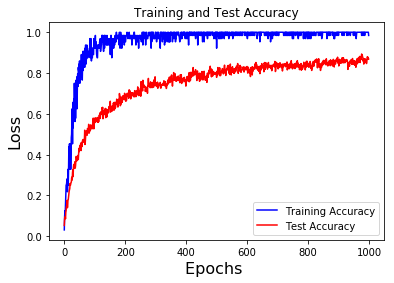

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

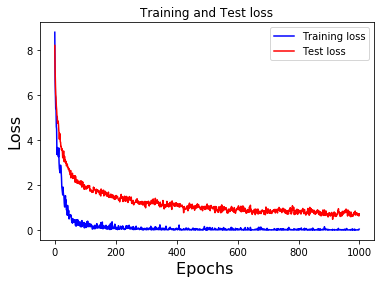

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

In [17]:
# saving the graph for warm training 
saver = tf.train.Saver()

save_path = saver.save(sess, "./Models/model"+str(time.localtime().tm_hour)+str(time.localtime().tm_min)+".ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ./Models/model52.ckpt


In [17]:
# restoring graph

# saver = tf.train.Saver()

# saver.restore(sess, "./Models/model2243.ckpt")
# export_dir = "./CompleteModelSave/"
# tf.saved_model.simple_save(sess,
#             export_dir,
#             inputs={"x": x},
#             outputs={"out": y})

INFO:tensorflow:Restoring parameters from ./Models/model2243.ckpt
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./CompleteModelSave/saved_model.pb


In [18]:
export_dir = "./CompleteModelSave/"
tf.saved_model.simple_save(sess,
            export_dir,
            inputs={"x": x},
            outputs={"myOutput": y})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./CompleteModelSave/saved_model.pb


[-1.1111108 -1.1111112 -1.1111112 -1.1111112 -1.1111112 -0.
 -1.1111112 -1.1111112 -1.1111112 -0.        -1.1111112 -1.1111112
 -1.1111112 -1.1111112 -1.1111112 -1.1111112 -1.1111112 -0.
 -1.1111112 -1.1111112 -1.1111112 -1.1111112 -0.        -0.
  1.1111112 -1.1109841]


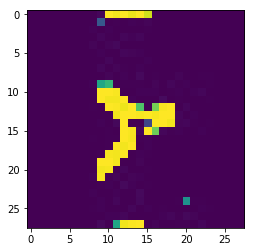

In [55]:
yyy = sess.run(yOut,feed_dict={x: test_X})
print((yyy[0]))
plt.imshow(test_X[0].reshape(28,28))
plt.show()

In [17]:
sess.close()

In [58]:
export_dir = './ModelSaver/'
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
builder.add_meta_graph_and_variables(sess, ["tag"], signature_def_map= {
        "model": tf.saved_model.signature_def_utils.predict_signature_def(
            inputs= {"x": x},
            outputs= {"myOutput": yOut})
        })
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./ModelSaver/saved_model.pb


b'./ModelSaver/saved_model.pb'